In [1]:
import os
import sys
import time
import glob
import io
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import layoutparser

In [2]:
nb_dir = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src'
sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

import config
import src.utilities.app_context as app_context
from src.utilities.primalaynet.infer import draw_box
app_context.init()
app_context.application_context = dict({'task_id': 'BM-DUMMY'})

#path to craft model, weight can be pulled form the production bracnh of repo
config.CRAFT_MODEL_PATH = "/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_mlt_25k.pth"
config.CRAFT_REFINE_MODEL_PATH  = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_refiner_CTW1500.pth' 


from src.services.main import generate_response,break_blocks,merge_vertically,merge_horizontally,extract_images_and_text_regions

Loading weights of refiner from checkpoint (./model/craft_refiner_CTW1500.pth)


In [3]:
import layoutparser as lp
model_primalaynet = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',label_map = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"},extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5])


In [4]:
def draw_box(filepath,desired_width, desired_height,save_dir, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    if type(df) is list:
        for i in df:
            for index, row in i.iterrows():
                left   = int(row['text_left'])
                right  = int(row['text_width'] + left)
                top    = int(row['text_top'])
                bottom = int(row["text_height"] + top)
                draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    else:

        for index, row in df.iterrows():
            left   = int(row['text_left'])
            right  = int(row['text_width'] + left)
            top    = int(row['text_top'])
            bottom = int(row["text_height"] + top)
            draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    save_filepath = os.path.join(save_dir, os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

In [5]:
#dir which contains the pdf file
input_dir = '/home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/'
#filename = 'footer_test.pdf'
#filename  = 'ncert.pdf'
#filename = 'test_table.pdf'
filename  = '13_SCOB_2020.pdf'


lang     = 'en'

In [6]:
[pdf_data,flags] = extract_images_and_text_regions(filename, input_dir,lang,page_layout='double_column')
[pdf_data,flags] = merge_horizontally([pdf_data,flags])
[pdf_data,flags] = merge_vertically([pdf_data,flags])
[pdf_data,flags] = break_blocks([pdf_data,flags])
#response        = generate_response([pdf_data,flags])

[2021-01-15 18:23:01,645] {loghandler.py:21} MainThread INFO in loghandler: document preprocessing started ===>
[2021-01-15 18:23:01,647] {loghandler.py:21} MainThread INFO in loghandler: created processing directories successfully /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/13_SCOB_2020_99de723c-5730-11eb-86f1-0f5aa41cc064
[2021-01-15 18:23:01,648] {loghandler.py:21} MainThread INFO in loghandler: filepath /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/13_SCOB_2020.pdf, working_dir /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/13_SCOB_2020_99de723c-5730-11eb-86f1-0f5aa41cc064
[2021-01-15 18:23:02,041] {loghandler.py:21} MainThread INFO in loghandler: Extracting xml of /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/13_SCOB

In [7]:
# width_ratio = pdf_data['page_width'] / pdf_data['pdf_image_width']
# height_ratio = pdf_data['page_height'] / pdf_data['pdf_image_height']
# predict_primanet(img_filepath,pdf_bg_img_filepaths,to_check[0],width_ratio,height_ratio)

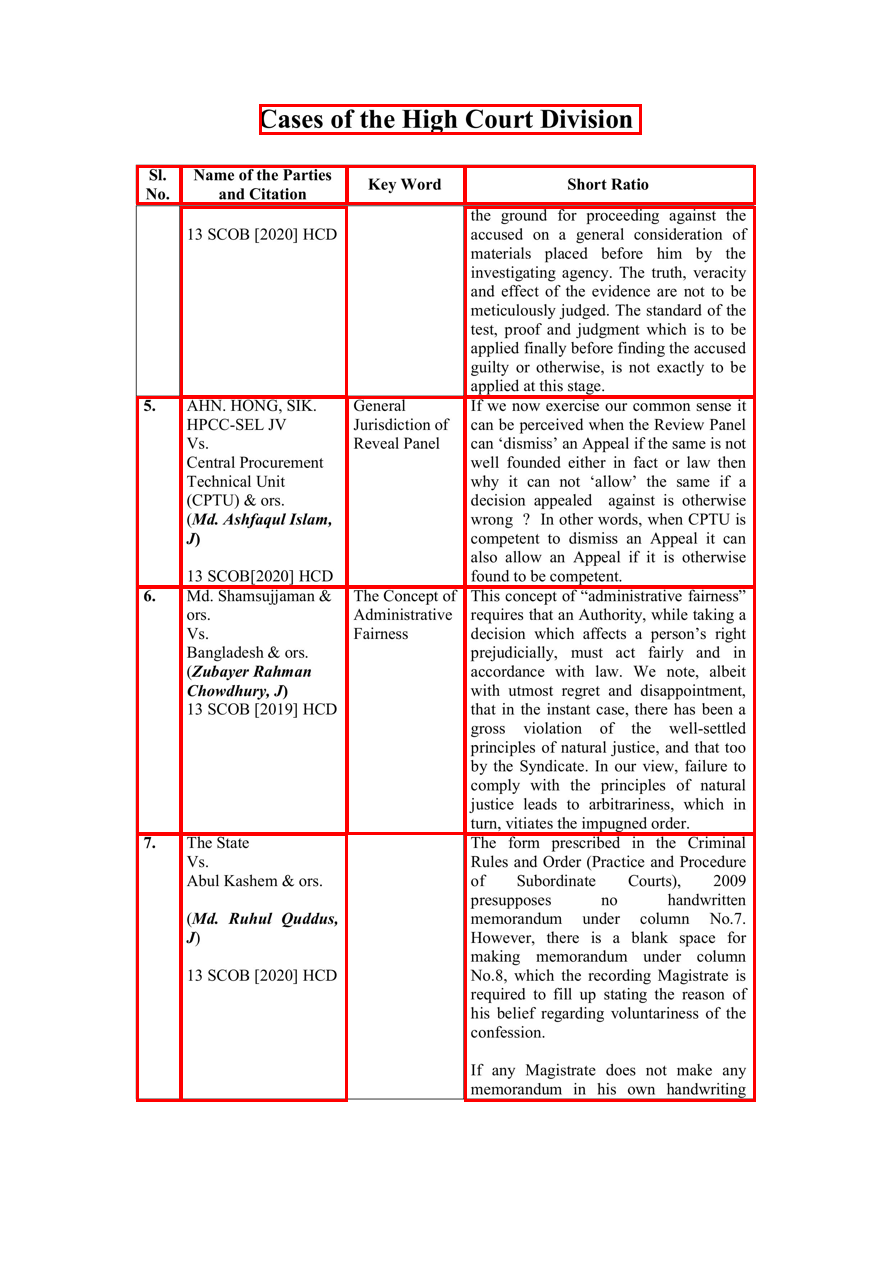

In [8]:
page_index = 1
to_check        = pdf_data['p_dfs']
#to_check_in_df        = pdf_data['v_dfs'][page_index]
img_filepath    = pdf_data['pdf_image_paths'][page_index]
pdf_bg_img_filepaths  = pdf_data['pdf_bg_img_filepaths'][page_index]
df              = to_check[page_index]

desired_width, desired_height = pdf_data['page_width'] , pdf_data['page_height']
draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)

In [9]:
df.sort_values(by=['text_top','text_left'])

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,font_family_updated,font_size_updated,children,avg_line_height
0,0,104,259,382,30,Cases of the High Court Division,26,UJTHNF+CairoFont-0-0,#000000,HEADER,CairoFont-0-0,26,None,30.0
1,NaN,165,136,45,39,Sl. No.,16,UJTHNF+CairoFont-0-0,#000000,TABLE,CairoFont-0-0,16,"{""xml_index"":{""0"":1,""1"":2},""text_top"":{""0"":166...",NaN
2,NaN,165,180,167,39,Name of the Parties and Citation,16,UJTHNF+CairoFont-0-0,#000000,TABLE,CairoFont-0-0,16,"{""xml_index"":{""0"":3,""1"":4},""text_top"":{""0"":166...",NaN
3,NaN,165,346,119,39,Key Word,16,UJTHNF+CairoFont-0-0,#000000,TABLE,CairoFont-0-0,16,"{""xml_index"":{""0"":5},""text_top"":{""0"":175},""tex...",NaN
4,NaN,165,464,291,39,Short Ratio,16,UJTHNF+CairoFont-0-0,#000000,TABLE,CairoFont-0-0,16,"{""xml_index"":{""0"":6},""text_top"":{""0"":175},""tex...",NaN
5,NaN,206,180,167,191,13 SCOB [2020] HCD,16,WORVBD+CairoFont-2-0,#000000,TABLE,CairoFont-2-0,16,"{""xml_index"":{""0"":7},""text_top"":{""0"":225},""tex...",NaN
6,NaN,206,464,291,191,the ground for proceeding against the a...,16,WORVBD+CairoFont-2-0,#000000,TABLE,CairoFont-2-0,16,"{""xml_index"":{""0"":8,""1"":9,""2"":10,""3"":11,""4"":12...",NaN
7,NaN,396,136,45,191,5,16,UJTHNF+CairoFont-0-0,#000000,TABLE,CairoFont-0-0,16,"{""xml_index"":{""0"":18},""text_top"":{""0"":397},""te...",NaN
8,NaN,396,180,167,191,"AHN. HONG, SIK. HPCC-SEL JV Vs. Centra...",16,WORVBD+CairoFont-2-0,#000000,TABLE,CairoFont-2-0,16,"{""xml_index"":{""0"":19,""1"":20,""2"":21,""3"":22,""4"":...",NaN
9,NaN,396,346,119,191,General Jurisdiction of Reveal Panel,16,WORVBD+CairoFont-2-0,#000000,TABLE,CairoFont-2-0,16,"{""xml_index"":{""0"":30,""1"":31,""2"":32},""text_top""...",NaN


In [10]:
pd.read_json(df['children'][1])#['text'].values

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,font_family_updated,font_size_updated,children
0,1,166,149,22,18,Sl.,16,UJTHNF+CairoFont-0-0,#000000,,CairoFont-0-0,16,NaN
1,2,185,146,28,18,No.,16,UJTHNF+CairoFont-0-0,#000000,,CairoFont-0-0,16,NaN


In [ ]:
for i in to_check_in_df['children']:
    d =pd.read_json(i)
    print(d)
    print(d['children'])

In [ ]:
import numpy as np
p_df_image = draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)
sc_pdf_image = draw_box(img_filepath,desired_width, desired_height, 'path',to_check_in_df, color="red", save=False)
stiched_imag = np.hstack([np.array(p_df_image) ,np.array(sc_pdf_image)])
compare_image = Image.fromarray(stiched_imag)
compare_image.save("/home/naresh/1.jpg")

In [ ]:
def predict_primanet(image_path,bg_image_path,in_df,width_ratio,height_ratio):
    image1  = cv2.imread(image_path)
    image2  = cv2.imread(bg_image_path)
    image = image1[..., ::-1] 
    layout = model_primalaynet.detect(image)
    boxes,coords = draw_box(layout, in_df,width_ratio,height_ratio)
    final_coord= []
    for coord in coords:
        temp_dict={}
        temp_dict['text_left']=coord[0]; temp_dict['text_top']=coord[1]
        temp_dict['text_width']=coord[2]; temp_dict['text_height']=coord[3]
        #draw.rectangle(coord, width=3,outline='red')
        final_coord.append(temp_dict)
        cv2.rectangle(image1, (int(coord[0]),int(coord[1])), (int(coord[2]),int(coord[3])),(255,255,0),3)
        cv2.rectangle(image2, (int(coord[0]*width_ratio),int(coord[1]*height_ratio)), (int(coord[2]*width_ratio),int(coord[3]*height_ratio)),(255,255,0),3)

        cv2.imwrite("1.jpg",image1)
        cv2.imwrite("2.jpg",image2)

    return final_coord